## Regression H3K36me3 and nucleosomes: Figure 4 and Supplementary Figure S6

In [31]:
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import scipy.stats as stats
import seaborn as sns
from scipy.stats import chi2
from statsmodels.robust.robust_linear_model import RLM
from bgreference import hg19

In [57]:
from python_scripts.plot_functions import config_plot_params
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})
config_plot_params()

In [32]:
# Included
coordinates_folder = 'data/coordinates/'

# Not included
histone_data_folder = 'non_provided_data/histonmarks/'

# Other
bin_size = 50

### Functions

In [33]:
def remove_version_ensembl(x, colname):
    """
    Remove version from the ensembl ID

    Args:
        x: dataframe row
        colname: column name

    Returns:
        str. Text before a '.'

    """
    ensembl_id = x[colname]
    ensembl_id_only = ensembl_id.split('.')[0]

    return ensembl_id_only

In [34]:
def add_muts(x, y, samplelvl_results_df):
    
    my_gene = x['ensembl']
    sub_samplelvl = samplelvl_results_df[samplelvl_results_df['ensembl'] == my_gene]
    
    exon_muts = sum(sub_samplelvl[y])
    
    return exon_muts

In [35]:
def compute_pval(obs_muts_1, obs_muts_2, exp_muts1_prob):
    """likelihood ratio test"""
    
    y = obs_muts_1
    N = obs_muts_1 + obs_muts_2
    p1 = y/N #probability of going exon according to the observed exon/intron muts

    p0 = exp_muts1_prob #expected probability of going exon
    
    logL1 = y*np.log(p1)+(N-y)*np.log(1-p1) #log likelihood according to p1
    logL0 = y*np.log(p0)+(N-y)*np.log(1-p0) #log likelihood according to p0
        
    my_chi2 = 2*(logL1-logL0)
    
    my_p = chi2.sf(my_chi2, 1) #chi2 score to pvalue
    
    return my_p

In [68]:
def compute_data_nucleosome_filter(histon_mark, bin_size, use_peaks, condition):
    
    histon_marks_lol = list()
    
    #Read precomputed results
    gene_dependent_results = path.join('results', "germinal_gene_dependent_results.txt") # Output from other notebook
    sample_dependent_results = path.join('results', "germinal_sample_dependent_results.txt")  # Output from other notebook

    genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
    samplelvl_results_df = pd.read_csv(sample_dependent_results, header='infer', sep='\t')
    
    samplelvl_results_df = samplelvl_results_df[samplelvl_results_df['sample']==condition]
        
    my_genes =  genelvl_results_df['ensembl'].tolist()

    my_genelevel_exp = list()

    ########
    #The goal of this first part is to get the number of obs & exp muts per gene
    #######

    #Iterate genes, computing the observed and expected intronic and exonic mutations
    #Also computes the expected syn and nonsyn muts, but i think its not needed
        
    for my_gene in my_genes:
        sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
        sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['ensembl'] == my_gene]

        exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
        introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

        exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
        introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

        exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
        intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

        total_muts = exon_muts+intron_muts

        exp_exon_muts = total_muts*exons_prob
        exp_intron_muts = total_muts*introns_prob

        syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
        nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

        syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
        nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

        syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
        nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

        total_cons_muts = syn_muts+nonsyn_muts

        exp_syn_muts = total_cons_muts*syn_prob
        exp_nonsyn_muts = total_cons_muts*nonsyn_prob

        exons_bp = sub_genelvl_results['exons_bp'].values[0]
        introns_bp = sub_genelvl_results['introns_bp'].values[0]

        my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                                 exp_intron_muts, syn_muts, exp_syn_muts, nonsyn_muts,
                                 exp_nonsyn_muts, exons_bp, introns_bp])

    my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
    my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                                   'exp_intron_muts', 'syn_muts', 'exp_syn_muts', 'nonsyn_muts',
                                   'exp_nonsyn_muts', 'exons_bp', 'introns_bp']
    
    ########
    #The goal of this second part is to get two histone mark values per gene:
    #One for the exons and one for the introns. 
    #######
    
    if use_peaks:
        ext = '.narrowPeak.gz'
    else:
        ext = '.tagAlign.gz'
    
    #Iterates histone marks list specified above and reads it
    #It also loads exon and intron coordinates
    print(histon_mark)
    
    introns_coords = path.join(coordinates_folder, 'germinal_filtered_introns_coords.txt')  # Output from other notebook
    middle_exons_coords = path.join(coordinates_folder, 'germinal_filtered_exons_coords.txt')  # Output from other notebook
    
    histone_reads_file = path.join('data', 'nucleosomes','nucleosome_coords.bed')
    histone_data_df = pd.read_csv(histone_reads_file, sep='\t', header=None)
    histone_data_df = histone_data_df[histone_data_df[3] >= 2.5]
    histone_data_df = histone_data_df[[0,1,2]]
    histone_data_df.columns = ['chr', 'start', 'end']
    # expand to cover the 147 bases of the nucleosome
    histone_data_df['start'] = histone_data_df['start'] - 73
    histone_data_df['end'] = histone_data_df['end'] + 73
    histone_data_df = histone_data_df[~histone_data_df['start'] < 0]
    
    histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)
    
    exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", low_memory=False)
    exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
    sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_df)
    
    my_exon_histon_bed = sub_exons_coords_bed.intersect(histon_mark_bed, wao=True)
    print(my_exon_histon_bed.head())
    my_exon_histon_df = pd.read_table(my_exon_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    my_exons_reads = my_exon_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_exons_reads = pd.DataFrame({'ensembl':my_exons_reads.index, 'exon_bases_covered':my_exons_reads.values})
    
    introns_coords_df = pd.read_csv(introns_coords, sep="\t", low_memory=False)
    introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']
    sub_introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_df)
    
    my_intron_histon_bed = sub_introns_coords_bed.intersect(histon_mark_bed, wao=True)
    print(my_intron_histon_bed.head())
    my_intron_histon_df = pd.read_table(my_intron_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    my_introns_reads = my_intron_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_introns_reads = pd.DataFrame({'ensembl':my_introns_reads.index, 'intron_bases_covered':my_introns_reads.values})

    my_merged_histon_reads = pd.merge(my_exons_reads, my_introns_reads, on='ensembl')

    ########
    #Next, it bins the genes based on the exon / intron proportion of the histone mark
    #######

    sub_results = genelvl_results_df

    sub_results['exon_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_exon_muts', samplelvl_results_df), axis=1)
    sub_results['intron_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_intron_muts', samplelvl_results_df), axis=1)

    sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                                (sub_results['exons_bp'] + sub_results['introns_bp']))
    sub_results = sub_results[sub_results['mutrate'] != 0]

    sub_results_histon = pd.merge(sub_results, my_merged_histon_reads, on='ensembl')

    sub_results_histon['exons_histon_rate'] = (sub_results_histon['exon_bases_covered']/
                                               sub_results_histon['exons_bp'])
    sub_results_histon['introns_histon_rate'] = (sub_results_histon['intron_bases_covered']/
                                                 sub_results_histon['introns_bp'])
    sub_results_histon['total_histon_rate'] = ((sub_results_histon['intron_bases_covered'] + sub_results_histon['exon_bases_covered'])/
                                                 (sub_results_histon['introns_bp'] + sub_results_histon['exons_bp']))
    sub_results_histon['ex_in_histon_fc'] = sub_results_histon['exons_histon_rate']/sub_results_histon['introns_histon_rate']

    filtered_results_histon = sub_results_histon[(sub_results_histon['exon_bases_covered'] != 0) &
                                           (sub_results_histon['intron_bases_covered'] != 0)]

    filtered_results_histon = filtered_results_histon.sort_values(by='ex_in_histon_fc', ascending=True)

    groups_size = int(len(filtered_results_histon.index.tolist()) / bin_size)

    histon_levels = dict()

    for i in range(bin_size):
        my_start = i * groups_size
        my_end = (i + 1) * groups_size

        if i == max(range(bin_size)):
            my_end = len(filtered_results_histon.index.tolist())

        sub_exin_prop_df = filtered_results_histon.iloc[my_start:my_end]
        sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()

        histon_levels[i] = sub_exin_genes

    exons_results_prop = list()
    introns_results_prop = list()
    results_for_printing = list()


    ########
    #For each of the bins, compute the decreased mutarate
    #######

    for histon_level in histon_levels:
        genes_list = histon_levels[histon_level]
        print(len(genes_list))

        my_median_ex_in_histon_fc = np.mean(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'])
        my_std = filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'].describe()['std']
        exons_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exons_bp'])
        introns_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['introns_bp'])

        obs_exon_muts = sum(samplelvl_results_df[samplelvl_results_df['ensembl'].isin(genes_list)]['obs_exon_muts'])
        obs_intron_muts = sum(samplelvl_results_df[samplelvl_results_df['ensembl'].isin(genes_list)]['obs_intron_muts'])

        total_muts = obs_exon_muts+obs_intron_muts

        obs_exons_rate = obs_exon_muts/exons_bp
        obs_introns_rate = obs_intron_muts/introns_bp

        exp_exon_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_exon_muts'])
        exp_intron_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_intron_muts'])

        exp_exons_rate = exp_exon_muts/exons_bp
        exp_introns_rate = exp_intron_muts/introns_bp

        exons_results_prop.append([histon_level, 'exon', obs_exons_rate, exp_exons_rate, obs_exon_muts, exp_exon_muts, my_median_ex_in_histon_fc, my_std])
        introns_results_prop.append([histon_level, 'intron', obs_introns_rate, exp_introns_rate, obs_intron_muts, exp_intron_muts, my_median_ex_in_histon_fc, my_std])

        #Results for printing

        average_exons_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exon_bases_covered'])
        average_introns_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['intron_bases_covered'])

        exp_exon_prob = exp_exon_muts/(obs_exon_muts+obs_intron_muts)

        my_p = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

        my_row = [histon_level, average_exons_reads, average_introns_reads,
                  obs_exon_muts, obs_intron_muts, exp_exon_muts, exp_intron_muts, my_p,
                  my_median_ex_in_histon_fc]

        results_for_printing.append(my_row)

    results_for_printing_df = pd.DataFrame(results_for_printing)
    results_for_printing_df.columns = ['histon_level', 'average_exons_reads', 'average_introns_reads',
                                      'obs_exon_muts', 'obs_intron_muts', 'exp_exon_muts', 'exp_introns_rate',
                                       'pvalue', 'median_fc']

    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'
    print(histone_type)
    
    file_name = 'germinal_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type + '_' + condition + '_exon_intron_print'
    results_for_printing_df.to_csv(path.join('results', file_name) + '.txt', sep='\t', header=True, index=None)

    results_prop_df = pd.concat([pd.DataFrame(exons_results_prop), pd.DataFrame(introns_results_prop)])
    results_prop_df.columns = ['bin', 'region', 'observed_mutrate', 'expected_mutrate', 'obs_muts', 'exp_muts', 'median_fc', 'std']

    results_prop_df['decrease_over_expected'] = -(results_prop_df['expected_mutrate']-results_prop_df['observed_mutrate'])/results_prop_df['expected_mutrate']*100

    ########
    #Prepare data
    #######

    tmp = results_prop_df[results_prop_df['region'] == 'exon'].copy()

    # Histon values per gene
    exin_bin_per_gene_lol = list()
    for histon_level in histon_levels:
        hist_level_genes  = histon_levels[histon_level]

        for my_gene in hist_level_genes:
            gene_exin = filtered_results_histon[filtered_results_histon['ensembl'] == my_gene]['ex_in_histon_fc'].values.tolist()[0]
            exin_bin_per_gene_lol.append([histon_level, gene_exin])

    fc_histone = pd.DataFrame(exin_bin_per_gene_lol)
    fc_histone.columns = ['bin', 'ex_in_histon_fc']
    
    decrease = tmp[['decrease_over_expected']]
    decrease.index = tmp['bin']

    y_coords = []
    x_coords = []

    # Collapse histone values using the mean
    for ind in decrease.index:
        y_coords += [decrease.loc[ind, 'decrease_over_expected']]
        fc_histone_slice = fc_histone[fc_histone['bin'] == ind]
        x_coords += [np.mean(fc_histone_slice['ex_in_histon_fc'].values)]
    
    df = pd.DataFrame({'decrease_over_expected': y_coords, 'mean_fc': x_coords, 'bin': decrease.index})

    file_name = 'germinal_'  + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type + '_' + condition + '_exon_intron.tsv'
    df.to_csv(path.join('results', file_name), sep='\t', header=True, index=None)

In [39]:
def compute_data_filter(histon_mark, bin_size, use_peaks, condition):
    
    histon_marks_lol = list()
    
    #Read precomputed results
    gene_dependent_results = path.join('results', "germinal_gene_dependent_results.txt") # Output from other notebook
    sample_dependent_results = path.join('results', "germinal_sample_dependent_results.txt")  # Output from other notebook

    genelvl_results_df = pd.read_csv(gene_dependent_results, sep='\t')
    samplelvl_results_df = pd.read_csv(sample_dependent_results, header='infer', sep='\t')
    
    samplelvl_results_df = samplelvl_results_df[samplelvl_results_df['sample']==condition]
    
    my_genes =  genelvl_results_df['ensembl'].tolist()

    my_genelevel_exp = list()

    ########
    #The goal of this first part is to get the number of obs & exp muts per gene
    #######

    #Iterate genes, computing the observed and expected intronic and exonic mutations
    #Also computes the expected syn and nonsyn muts, but i think its not needed
        
    for my_gene in my_genes:
        sub_genelvl_results = genelvl_results_df[genelvl_results_df['ensembl'] == my_gene]
        sub_samplelvl_results = samplelvl_results_df[samplelvl_results_df['ensembl'] == my_gene]

        exons_products_sum = sub_genelvl_results['exons_products_sum'].values[0]
        introns_products_sum = sub_genelvl_results['introns_products_sum'].values[0]

        exons_prob = exons_products_sum/(exons_products_sum+introns_products_sum)
        introns_prob = introns_products_sum/(exons_products_sum+introns_products_sum)

        exon_muts = sum(sub_samplelvl_results['obs_exon_muts'])
        intron_muts = sum(sub_samplelvl_results['obs_intron_muts'])

        total_muts = exon_muts+intron_muts

        exp_exon_muts = total_muts*exons_prob
        exp_intron_muts = total_muts*introns_prob

        syn_products_sum = sub_genelvl_results['syn_products_sum'].values[0]
        nonsyn_products_sum = sub_genelvl_results['nonsyn_products_sum'].values[0]

        syn_prob = syn_products_sum/(syn_products_sum+nonsyn_products_sum)
        nonsyn_prob = nonsyn_products_sum/(syn_products_sum+nonsyn_products_sum)

        syn_muts = sum(sub_samplelvl_results['obs_syn_muts'])
        nonsyn_muts = sum(sub_samplelvl_results['obs_nonsyn_muts'])

        total_cons_muts = syn_muts+nonsyn_muts

        exp_syn_muts = total_cons_muts*syn_prob
        exp_nonsyn_muts = total_cons_muts*nonsyn_prob

        exons_bp = sub_genelvl_results['exons_bp'].values[0]
        introns_bp = sub_genelvl_results['introns_bp'].values[0]

        my_genelevel_exp.append([my_gene, exon_muts, exp_exon_muts, intron_muts,
                                 exp_intron_muts, syn_muts, exp_syn_muts, nonsyn_muts,
                                 exp_nonsyn_muts, exons_bp, introns_bp])

    my_genelevel_exp_df = pd.DataFrame(my_genelevel_exp)
    my_genelevel_exp_df.columns = ['ensembl', 'exon_muts', 'exp_exon_muts', 'intron_muts',
                                   'exp_intron_muts', 'syn_muts', 'exp_syn_muts', 'nonsyn_muts',
                                   'exp_nonsyn_muts', 'exons_bp', 'introns_bp']
    
    ########
    #The goal of this second part is to get two histone mark values per gene:
    #One for the exons and one for the introns. 
    #######

    if use_peaks:
        ext = '.narrowPeak.gz'
    else:
        ext = '.tagAlign.gz'
    
    #Iterates histone marks list specified above and reads it
    #It also loads exon and intron coordinates
    print(histon_mark)
    
    introns_coords = path.join(coordinates_folder, 'germinal_filtered_introns_coords.txt')  # Output from other notebook
    middle_exons_coords = path.join(coordinates_folder, 'germinal_filtered_exons_coords.txt')  # Output from other notebook
    
    histone_reads_file = path.join(histone_data_folder, '{}{}'.format(histon_mark, ext))
    histone_data_df = pd.read_csv(histone_reads_file, sep='\t', header=None)
    histone_data_df = histone_data_df[[0,1,2]]
    histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)

    exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", low_memory=False)
    exons_coords_df['ensembl'] = exons_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl']

    sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(exons_coords_df)
    
    my_exon_histon_bed = sub_exons_coords_bed.intersect(histon_mark_bed, wao=True)
    my_exon_histon_df = pd.read_table(my_exon_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    
    my_exons_reads = my_exon_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_exons_reads = pd.DataFrame({'ensembl':my_exons_reads.index, 'exon_bases_covered':my_exons_reads.values})
    
    introns_coords_df = pd.read_csv(introns_coords, sep="\t", low_memory=False)
    introns_coords_df['ensembl'] = introns_coords_df.apply(lambda x: remove_version_ensembl(x, 'ensembl'), axis=1)
    introns_coords_df.columns = ['chr', 'start', 'end', 'ensembl']

    sub_introns_coords_bed = pybedtools.BedTool.from_dataframe(introns_coords_df)
    
    my_intron_histon_bed = sub_introns_coords_bed.intersect(histon_mark_bed, wao=True)
    my_intron_histon_df = pd.read_table(my_intron_histon_bed.fn, names = ['region_chr', 'region_start', 'region_end',
                            'ensembl', 'read_chr', 'read_start', 'read_end', 'overlap_bp'])
    
    my_introns_reads = my_intron_histon_df.groupby('ensembl')['overlap_bp'].sum()
    my_introns_reads = pd.DataFrame({'ensembl':my_introns_reads.index, 'intron_bases_covered':my_introns_reads.values})

    my_merged_histon_reads = pd.merge(my_exons_reads, my_introns_reads, on='ensembl')

    ########
    #Next, it bins the genes based on the exon / intron proportion of the histone mark
    #######

    sub_results = genelvl_results_df

    sub_results['exon_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_exon_muts', samplelvl_results_df), axis=1)
    sub_results['intron_muts'] = sub_results.apply(lambda x: add_muts(x, 'obs_intron_muts', samplelvl_results_df), axis=1)

    sub_results['mutrate'] = ((sub_results['exon_muts'] + sub_results['intron_muts']) /
                                (sub_results['exons_bp'] + sub_results['introns_bp']))
    sub_results = sub_results[sub_results['mutrate'] != 0]

    sub_results_histon = pd.merge(sub_results, my_merged_histon_reads, on='ensembl')

    sub_results_histon['exons_histon_rate'] = (sub_results_histon['exon_bases_covered']/
                                               sub_results_histon['exons_bp'])
    sub_results_histon['introns_histon_rate'] = (sub_results_histon['intron_bases_covered']/
                                                 sub_results_histon['introns_bp'])
    sub_results_histon['total_histon_rate'] = ((sub_results_histon['intron_bases_covered'] + sub_results_histon['exon_bases_covered'])/
                                                 (sub_results_histon['introns_bp'] + sub_results_histon['exons_bp']))
    sub_results_histon['ex_in_histon_fc'] = sub_results_histon['exons_histon_rate']/sub_results_histon['introns_histon_rate']

    filtered_results_histon = sub_results_histon[(sub_results_histon['exon_bases_covered'] != 0) &
                                           (sub_results_histon['intron_bases_covered'] != 0)]

    filtered_results_histon = filtered_results_histon.sort_values(by='ex_in_histon_fc', ascending=True)

    groups_size = int(len(filtered_results_histon.index.tolist()) / bin_size)

    histon_levels = dict()

    for i in range(bin_size):
        my_start = i * groups_size
        my_end = (i + 1) * groups_size

        if i == max(range(bin_size)):
            my_end = len(filtered_results_histon.index.tolist())

        sub_exin_prop_df = filtered_results_histon.iloc[my_start:my_end]
        sub_exin_genes = sub_exin_prop_df['ensembl'].tolist()
        print(len(sub_exin_genes))

        histon_levels[i] = sub_exin_genes

    exons_results_prop = list()
    introns_results_prop = list()
    results_for_printing = list()


    ########
    #For each of the bins, compute the decreased mutarate
    #######


    for histon_level in histon_levels:
        genes_list = histon_levels[histon_level]

        my_median_ex_in_histon_fc = np.mean(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'])
        my_std = filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['ex_in_histon_fc'].describe()['std']
        exons_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exons_bp'])
        introns_bp = sum(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['introns_bp'])

        obs_exon_muts = sum(samplelvl_results_df[samplelvl_results_df['ensembl'].isin(genes_list)]['obs_exon_muts'])
        obs_intron_muts = sum(samplelvl_results_df[samplelvl_results_df['ensembl'].isin(genes_list)]['obs_intron_muts'])

        total_muts = obs_exon_muts+obs_intron_muts

        obs_exons_rate = obs_exon_muts/exons_bp
        obs_introns_rate = obs_intron_muts/introns_bp

        exp_exon_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_exon_muts'])
        exp_intron_muts = sum(my_genelevel_exp_df[my_genelevel_exp_df['ensembl'].isin(genes_list)]['exp_intron_muts'])

        exp_exons_rate = exp_exon_muts/exons_bp
        exp_introns_rate = exp_intron_muts/introns_bp

        exons_results_prop.append([histon_level, 'exon', obs_exons_rate, exp_exons_rate, obs_exon_muts, exp_exon_muts, my_median_ex_in_histon_fc, my_std])
        introns_results_prop.append([histon_level, 'intron', obs_introns_rate, exp_introns_rate, obs_intron_muts, exp_intron_muts, my_median_ex_in_histon_fc, my_std])

        #Results for printing

        average_exons_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['exon_bases_covered'])
        average_introns_reads = np.average(filtered_results_histon[filtered_results_histon['ensembl'].isin(genes_list)]['intron_bases_covered'])

        exp_exon_prob = exp_exon_muts/(obs_exon_muts+obs_intron_muts)

        my_p = compute_pval(obs_exon_muts, obs_intron_muts, exp_exon_prob)

        my_row = [histon_level, average_exons_reads, average_introns_reads,
                  obs_exon_muts, obs_intron_muts, exp_exon_muts, exp_intron_muts, my_p,
                  my_median_ex_in_histon_fc]

        results_for_printing.append(my_row)

    results_for_printing_df = pd.DataFrame(results_for_printing)
    results_for_printing_df.columns = ['histon_level', 'average_exons_reads', 'average_introns_reads',
                                      'obs_exon_muts', 'obs_intron_muts', 'exp_exon_muts', 'exp_introns_rate',
                                       'pvalue', 'median_fc']

    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'
    print(histone_type)
    
    file_name = 'germinal_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type  + '_' + condition + '_exon_intron_print'
    results_for_printing_df.to_csv(path.join('results', file_name) + '.txt', sep='\t', header=True, index=None)

    results_prop_df = pd.concat([pd.DataFrame(exons_results_prop), pd.DataFrame(introns_results_prop)])
    results_prop_df.columns = ['bin', 'region', 'observed_mutrate', 'expected_mutrate', 'obs_muts', 'exp_muts', 'median_fc', 'std']

    results_prop_df['decrease_over_expected'] = -(results_prop_df['expected_mutrate']-results_prop_df['observed_mutrate'])/results_prop_df['expected_mutrate']*100

    ########
    #Prepare data
    #######

    tmp = results_prop_df[results_prop_df['region'] == 'exon'].copy()

    # Histon values per gene
    exin_bin_per_gene_lol = list()
    for histon_level in histon_levels:
        hist_level_genes  = histon_levels[histon_level]

        for my_gene in hist_level_genes:
            gene_exin = filtered_results_histon[filtered_results_histon['ensembl'] == my_gene]['ex_in_histon_fc'].values.tolist()[0]
            exin_bin_per_gene_lol.append([histon_level, gene_exin])

    fc_histone = pd.DataFrame(exin_bin_per_gene_lol)
    fc_histone.columns = ['bin', 'ex_in_histon_fc']
    
    decrease = tmp[['decrease_over_expected']]
    decrease.index = tmp['bin']

    y_coords = []
    x_coords = []

    # Collapse histone values using the mean
    for ind in decrease.index:
        y_coords += [decrease.loc[ind, 'decrease_over_expected']]
        fc_histone_slice = fc_histone[fc_histone['bin'] == ind]
        x_coords += [np.mean(fc_histone_slice['ex_in_histon_fc'].values)]
    
    df = pd.DataFrame({'decrease_over_expected': y_coords, 'mean_fc': x_coords, 'bin': decrease.index})

    file_name = 'germinal_'  + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type + '_' + condition + '_exon_intron.tsv'
    df.to_csv(path.join('results', file_name), sep='\t', header=True, index=None)

In [65]:
def do_plot_filter(histon_mark, bin_size, use_peaks, panel_name, size, condition):
    
    if use_peaks:
        histone_type = 'peaks'
    else:
        histone_type = 'reads'
    
    file_name = 'germinal_' + str(bin_size) + '_bins_' + histon_mark + '_' + histone_type + '_' + condition + '_exon_intron.tsv'
    data_df = pd.read_csv(path.join('results', file_name), sep="\t")
    
    x=data_df["mean_fc"].values.tolist()
    y=data_df["decrease_over_expected"].values.tolist()
    
    exog_data = provide_exog(y)
    model_irls = RLM(x, exog_data)

    res_irls = model_irls.fit()
    res_irls.summary2()

    pval = 2 * stats.t.sf(np.abs(res_irls.tvalues[0]), res_irls.df_resid)
    weighted_r = w_corr(x, y, res_irls.weights)

    fig = plt.figure(figsize=size)
    ax = plt.subplot2grid((1, 1), (0, 0))

    ax = sns.regplot(x="mean_fc", y="decrease_over_expected", data=data_df, scatter_kws={'s':25},
                    line_kws={'color':'#db2f34', 'lw':1})
    ax.set_ylim(-50, 50)

    ax.set_ylabel('Exonic mutations difference (%)')
    ax.set_xlabel(histon_mark.split('.')[0] + ' exon to intron ratio')

    ax.margins(0.05)

    for axis in ['right', 'top']:
        ax.spines[axis].set_visible(False)

    for axis in ['bottom', 'left']:
        ax.spines[axis].set_position(('axes', -0.01))

    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    plt.text(4, 35, 'r = ' + str(round(weighted_r, 2)), fontsize=8)
    plt.text(4, 30, 'P = ' + str(eformat(pval, 2, 2)), fontsize=8)

    print(weighted_r, pval)
    
    ax.set_title("Germline cells (n = 3,195 trios)")
    
    plt.savefig(path.join('figures', 'figure4'+ panel_name +'.svg'), bbox_inches='tight')

    plt.show()

### Execute (healthy)

In [27]:
compute_data_filter('E003-H3K36me3', bin_size, False, 'healthy')

E003-H3K36me3
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
144
159
reads


In [69]:
compute_data_nucleosome_filter('nucleosomes', bin_size, False, 'healthy')

nucleosomes
chr1	738799	738811	ENSG00000269831	.	-1	-1	0
 chr1	896672	896932	ENSG00000187961	.	-1	-1	0
 chr1	897008	897130	ENSG00000187961	.	-1	-1	0
 chr1	897205	897427	ENSG00000187961	.	-1	-1	0
 chr1	897734	897851	ENSG00000187961	chr1	897600	897747	13
 chr1	898083	898297	ENSG00000187961	chr1	898023	898170	87
 chr1	898488	898633	ENSG00000187961	.	-1	-1	0
 chr1	898716	898884	ENSG00000187961	chr1	898726	898873	147
 chr1	899299	899388	ENSG00000187961	.	-1	-1	0
 chr1	899486	899560	ENSG00000187961	.	-1	-1	0
 None
chr1	739108	739120	ENSG00000269831	.	-1	-1	0
 chr1	818172	818201	ENSG00000269308	chr1	818101	818248	29
 chr1	818298	818309	ENSG00000269308	.	-1	-1	0
 chr1	818543	818564	ENSG00000269308	chr1	818485	818632	21
 chr1	818576	818589	ENSG00000269308	chr1	818485	818632	13
 chr1	818590	818603	ENSG00000269308	chr1	818485	818632	13
 chr1	818666	818677	ENSG00000269308	.	-1	-1	0
 chr1	819001	819004	ENSG00000269308	.	-1	-1	0
 chr1	819658	819668	ENSG00000269308	chr1	819662	819809	6
 chr1	819906	8

-0.0291589864191 0.840904092647


/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


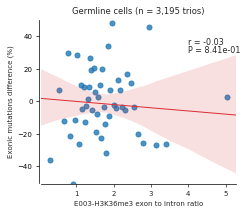

In [66]:
do_plot_filter('E003-H3K36me3', bin_size, False, 'C', (3.5, 3), 'healthy')

-0.283490370452 0.0537531887835


/home/peluca/anaconda3/envs/intronexon/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


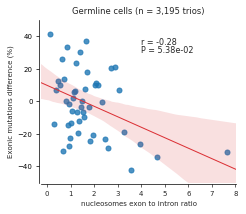

In [67]:
do_plot_filter('nucleosomes', bin_size, False, 'D', (3.5, 3), 'healthy')